In [1]:
import pandas as pd

In [2]:
trades = pd.read_csv('md_sim/trades_1000pepeusdt.csv')
trades.head()

,local_timestamp,side,price,amount
0,1723248002453757,buy,0.008519,748
1,1723248002466531,sell,0.008519,1944
2,1723248002466536,sell,0.008519,56
3,1723248002478602,buy,0.008519,28998
4,1723248002478610,buy,0.008519,7202


In [3]:
trades.sort_values(by='local_timestamp', inplace=True)

In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

class Candle:
    def __init__(self, time_start, time_end, body_open, body_close, shadow_max, shadow_min, 
                 buy_volume, sell_volume, buy_mean_price, sell_mean_price):
        self.time_start = time_start
        self.time_end = time_end
        self.body_open = body_open
        self.body_close = body_close
        self.shadow_max = shadow_max
        self.shadow_min = shadow_min
        self.buy_volume = buy_volume
        self.sell_volume = sell_volume
        self.buy_mean_price = buy_mean_price
        self.sell_mean_price = sell_mean_price

    def __str__(self):
        return (f"Candle({self.time_start} - {self.time_end}): "
                f"Open={self.body_open}, Close={self.body_close}, "
                f"High={self.shadow_max}, Low={self.shadow_min}, "
                f"Buy Volume={self.buy_volume}, Sell Volume={self.sell_volume}, "
                f"Avg Buy Price={self.buy_mean_price}, Avg Sell Price={self.sell_mean_price}")


def create_candles_df(trades, candle_duration_ns):
    # Создаем новый столбец для группировки сделок по временным интервалам
    trades['candle_interval'] = (trades['local_timestamp'] // candle_duration_ns) * candle_duration_ns
    
    # Группируем сделки по временным интервалам и вычисляем основные элементы свечи
    grouped = trades.groupby('candle_interval').agg(
        time_start=('local_timestamp', 'min'),  # Начало свечи
        time_end=('local_timestamp', 'max'),    # Конец свечи
        body_open=('price', 'first'),  # Цена открытия свечи
        body_close=('price', 'last'),  # Цена закрытия свечи
        shadow_max=('price', 'max'),   # Максимальная цена (верхняя тень)
        shadow_min=('price', 'min'),   # Минимальная цена (нижняя тень)
        
        # Средний объём сделок (buy и sell)
        buy_volume=('amount', lambda x: x[trades.loc[x.index, 'side'] == 'buy'].mean()),  # Средний объем покупок
        sell_volume=('amount', lambda x: x[trades.loc[x.index, 'side'] == 'sell'].mean()),  # Средний объем продаж
        
        # Средняя цена для покупок и продаж
        buy_mean_price=('price', lambda x: x[trades.loc[x.index, 'side'] == 'buy'].mean()),  # Средняя цена покупок
        sell_mean_price=('price', lambda x: x[trades.loc[x.index, 'side'] == 'sell'].mean())  # Средняя цена продаж
    ).reset_index()
    
    return grouped


def create_candles_from_df(candles_df):
    # List to store the Candle objects
    candles = []
    
    # Iterate over each row in the DataFrame to create Candle objects
    for _, row in candles_df.iterrows():
        candle = Candle(
            time_start=row['time_start'],
            time_end=row['time_end'],
            body_open=row['body_open'],
            body_close=row['body_close'],
            shadow_max=row['shadow_max'],
            shadow_min=row['shadow_min'],
            buy_volume=row['buy_volume'],
            sell_volume=row['sell_volume'],
            buy_mean_price=row['buy_mean_price'],
            sell_mean_price=row['sell_mean_price']
        )
        candles.append(candle)
    
    return candles


def make_candles(trades, candle_duration_ms=100000):
    # Преобразуем продолжительность в миллисекундах в наносекунды
    candle_duration_ns = candle_duration_ms * 1e3
    
    # Создание сводной таблицы с необходимыми полями
    candles_df = create_candles_df(trades, candle_duration_ns)
    
    # Создание объектов Candle из DataFrame
    candles = create_candles_from_df(candles_df)
    
    return candles

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

def plot_candles(candles):
    fig, ax = plt.subplots(figsize=(12, 6))
        
    # Определяем ширину тела свечи и ширину тени пропорционально количеству свечей
    candle_width = 3 / len(candles)  # Минимальная ширина тела свечи 0.4
    shadow_width = 1.5

    # Подготовка данных для отображения
    times = [candle.time_start for candle in candles]
    body_open_prices = [candle.body_open for candle in candles]
    body_close_prices = [candle.body_close for candle in candles]
    shadow_max_prices = [candle.shadow_max for candle in candles]
    shadow_min_prices = [candle.shadow_min for candle in candles]

    # Преобразуем времена в формат для matplotlib
    time_labels = [pd.to_datetime(ts * 1000, unit='ns') for ts in times]
    time_labels_num = mdates.date2num(time_labels)

    for i in range(len(candles)):
        candle = candles[i]
        color = 'green' if candle.body_close > candle.body_open else 'red'
        
        # Рисуем тело свечи (прямоугольник)
        ax.add_patch(plt.Rectangle(
            (time_labels_num[i] - candle_width / 2, min(candle.body_open, candle.body_close)),  # Нижняя левая точка
            candle_width,  # Ширина
            abs(candle.body_close - candle.body_open),  # Высота (разница между ценой открытия и закрытия)
            color=color
        ))
        
        # Рисуем верхнюю тень (линия от max до закрытия или открытия)
        ax.plot([time_labels_num[i], time_labels_num[i]], [candle.shadow_max, max(candle.body_open, candle.body_close)], 
                color=color, lw=shadow_width)
        
        # Рисуем нижнюю тень (линия от min до открытия или закрытия)
        ax.plot([time_labels_num[i], time_labels_num[i]], [candle.shadow_min, min(candle.body_open, candle.body_close)], 
                color=color, lw=shadow_width)
    
    # Настройка осей
    ax.set_xlim(min(time_labels_num), max(time_labels_num))
    ax.set_xlabel('Time')
    ax.set_ylabel('Price')
    ax.set_title('Candlestick Chart')
    
    # Форматирование оси x для отображения времени
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
    
    plt.grid(True)
    plt.gcf().autofmt_xdate()  # Поворачиваем метки времени для лучшего отображения
    plt.show()

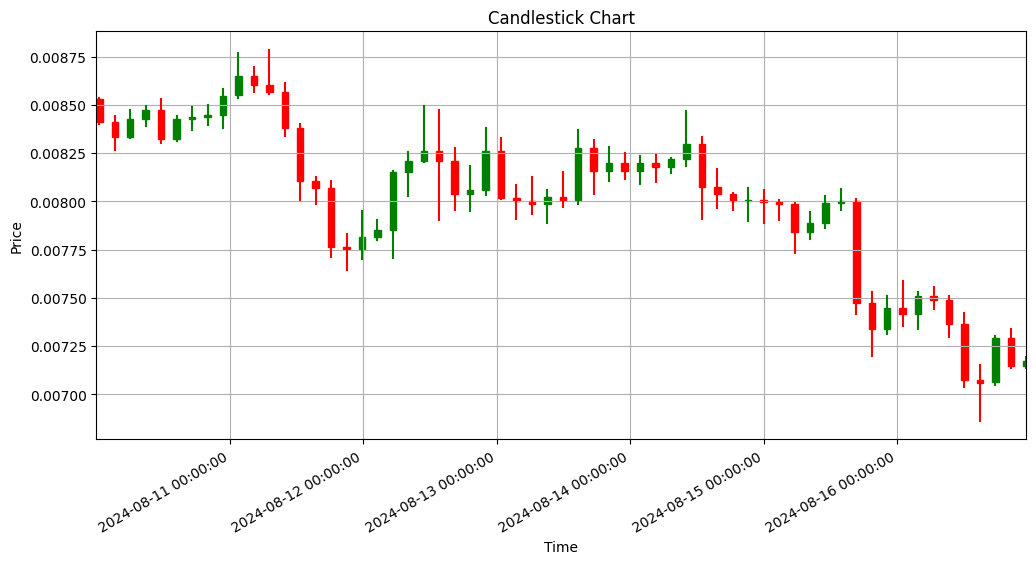

In [6]:
candles = make_candles(trades=trades, candle_duration_ms=1e7)
plot_candles(candles)

In [7]:
class BaseAction:
    def __init__(self, instrument, amount):
        self.instrument = instrument # Имя инструмента
        self.amount = amount # Сколько надо проторговать
    
class Action:
    def __init__(self, timestamp, base_actions):
        self.timestamp = timestamp
        self.base_actions = base_actions

In [8]:
def binary_search_next_trade(trades, target_time):
    # Предполагаем, что trades — это датафрейм, отсортированный по 'local_timestamp'
    
    left, right = 0, len(trades) - 1
    result = None
    
    while left <= right:
        mid = (left + right) // 2
        mid_time = trades.iloc[mid]['local_timestamp']
        
        if mid_time > target_time:
            result = trades.iloc[mid]  # Сохраняем возможный ответ
            right = mid - 1  # Ищем дальше в левой части
        else:
            left = mid + 1  # Ищем дальше в правой части
    
    return left  # Возвращаем ближайшую следующую строку или None


In [9]:
def perform_base_action(timestamp, base_action, bbo_data, duration):
    
    balance_delta = 0
    instrument_delta = 0
    
    amount = base_action.amount

    idx = binary_search_next_trade(bbo_data, timestamp)
    if not idx:
        idx = bbo_data.shape[0] - 1
        
    cur_timestamp = bbo_data.iloc[idx].local_timestamp

    while cur_timestamp < timestamp + duration and abs(base_action.amount) > 0 and idx < bbo_data.shape[0]:
        
        row = bbo_data.iloc[idx]
        cur_timestamp = row.local_timestamp
                
        if base_action.amount > 0: # Покупаем
            amount = min(row.ask_amount, base_action.amount)
            bbo_data.iloc[idx].ask_amount -= amount
            
        if base_action.amount < 0: # Покупаем
            amount = max(-row.bid_amount, base_action.amount)
            bbo_data.iloc[idx].bid_amount += amount
            
        base_action.amount -= amount
        
        instrument_delta += amount
        balance_delta -= row.ask_price * amount
        
        idx += 1

    
    return {'instrument_delta': instrument_delta, 'balance_delta': balance_delta} 
        

In [10]:
class Simulate:
    def __init__(self, actions, action_duration, verbose=False):
        """action_duration: ms"""
        self.actions = actions
        self.pnl = None
        self.traded_volume = 0
        
        self.verbose = verbose
        
        self.portfolio = {'DOGE': 0, 'PEPE': 0}
        
        self.balance = 0
        self.action_duration = action_duration * 1000 # первели в микросекунды
        
        
    def backtest(self, bbo_data):
        self.actions.sort(key = lambda action: action.timestamp)
        
        for action in self.actions:
            timestamp = action.timestamp
            for base_action in action.base_actions:
                instrument = base_action.instrument
                
                result = perform_base_action(timestamp=action.timestamp,
                                             base_action=base_action,
                                             bbo_data=bbo_data[instrument],
                                             duration = self.action_duration)
                
                balance_delta = result['balance_delta']
                instrument_delta = result['instrument_delta']
                
                self.balance += result['balance_delta']
                self.portfolio[instrument] += result['instrument_delta']
                
                if self.verbose:
                    print(f'Performed action: {instrument_delta} {instrument}')
                
        return {'balance': self.balance, 'open_positions': self.portfolio}

In [11]:
bbo_doge = pd.read_csv('md_sim/bbo_dogeusdt.csv')
bbo_pepe = pd.read_csv('md_sim/bbo_1000pepeusdt.csv')

bbo_data = {'DOGE': bbo_doge, 'PEPE': bbo_pepe}

bbo_data['DOGE'].sort_values(by='local_timestamp', inplace=True)
bbo_data['PEPE'].sort_values(by='local_timestamp', inplace=True)

bbo_data

{'DOGE':           local_timestamp  ask_amount  ask_price  bid_price  bid_amount
 0        1723248002491221      6702.0    0.10379    0.10378    168898.0
 1        1723248002964927     45492.0    0.10379    0.10378    151776.0
 2        1723248003458198    102183.0    0.10379    0.10378    160925.0
 3        1723248003968033     19688.0    0.10379    0.10378    178972.0
 4        1723248004498136     53459.0    0.10379    0.10378    172663.0
 ...                   ...         ...        ...        ...         ...
 1192269  1723852797832565     55085.0    0.10029    0.10028    101565.0
 1192270  1723852798435024     55154.0    0.10029    0.10028    101669.0
 1192271  1723852798949420     59061.0    0.10029    0.10028     93451.0
 1192272  1723852799297765     81285.0    0.10029    0.10028      6626.0
 1192273  1723852799906680    131770.0    0.10029    0.10028      2996.0
 
 [1192274 rows x 5 columns],
 'PEPE':           local_timestamp  ask_amount  ask_price  bid_price  bid_amount
 0  

Самая базовая страта

In [12]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
action1 = Action(timestamp=1723248002491221,
                 base_actions=[BaseAction(instrument='DOGE', amount=-10000)])

action2 = Action(timestamp=1723852797832565,
                  base_actions=[BaseAction(instrument='DOGE', amount=10000)])

actions = [action1, action2]

simulation = Simulate(actions=actions, action_duration=1000, verbose=True) # 1000мс длится действие

simulation.backtest(bbo_data=bbo_data)

Performed action: -10000 DOGE
Performed action: 10000 DOGE


{'balance': 34.99999999999977, 'open_positions': {'DOGE': 0, 'PEPE': 0}}

Мы открытыли короткую позицию вначале и закрыли её через несколько дней, итоговая прибыль 34.99 долларов. Все открытые позиции были закрыты.

Теперь посмотрим на то, как работает случайная стратегия

In [14]:
import random


def generate_random_actions(time_start=1723248002491221, time_end=1723852797832565, N=100):
    """Функция, генерирующая случайную последовательность из N действий в заданном промежутке времени"""
    time_stop = time_end - 1e3 * 1e3 * 60 # Перестанем генерировать случайные действия за минуту до конца, чтобы закрыть открытые позиции
    
    dt = (time_stop - time_start) / N
    
    instruments = ['DOGE', 'PEPE']
    total = dict(zip(instruments, [0] * len(instruments))) # Здесь будем хранить открытые позиции
    
    actions = []
    
    for i in range(N):
        amount = random.randint(-1000, 1000)
        instrument = instruments[random.randint(0, 1)]
        actions.append(
            Action(timestamp=time_start + i * dt,
                    base_actions=[BaseAction(instrument=instrument, amount=amount)])
        )
        
        total[instrument] += amount
        
    for instrument in instruments:
        actions.append(
            Action(timestamp=time_stop,
                        base_actions=[BaseAction(instrument=instrument, amount=-total[instrument])]))
    
    return actions

actions = generate_random_actions()
simulation = Simulate(actions=actions, action_duration=1000, verbose=True) # 1000мс длится действие

simulation.backtest(bbo_data=bbo_data)

Performed action: -272 PEPE
Performed action: 674 DOGE
Performed action: -915.0 DOGE
Performed action: 807 PEPE
Performed action: -917 DOGE
Performed action: -730 PEPE
Performed action: -150 PEPE
Performed action: 695 DOGE
Performed action: 654 PEPE
Performed action: 491 DOGE
Performed action: 347 PEPE
Performed action: -623 PEPE
Performed action: -299 PEPE
Performed action: 835 PEPE
Performed action: -274 DOGE
Performed action: 84 DOGE
Performed action: -103 PEPE
Performed action: 176 PEPE
Performed action: 365 PEPE
Performed action: 353 DOGE
Performed action: -654 PEPE
Performed action: 168 PEPE
Performed action: 695 PEPE
Performed action: -927 DOGE
Performed action: -203 PEPE
Performed action: 940 DOGE
Performed action: -572 DOGE
Performed action: -660 PEPE
Performed action: 201 DOGE
Performed action: -355 DOGE
Performed action: 888 DOGE
Performed action: 948 DOGE
Performed action: -134 DOGE
Performed action: 580 PEPE
Performed action: -391 DOGE
Performed action: -21 DOGE
Performed 

{'balance': 7.930872199999987, 'open_positions': {'DOGE': 0.0, 'PEPE': 0}}

Запустим случайную стратегию несколько раз, посмотрим на её среднюю доходность

In [15]:
yield_random = 0

t = 10
for i in range(t):
    actions = generate_random_actions()
    simulation = Simulate(actions=actions, action_duration=1000, verbose=False) # 1000мс длится действие

    result = simulation.backtest(bbo_data=bbo_data)
    
    if result['open_positions'] == {'DOGE': 0, 'PEPE': 0.0}:
        result_balance = result['balance']
        print(f'{i+1} run of random startegy yielded {result_balance:.4f} $')
        yield_random += result['balance']
        
print(f'Mean yield of random strategy: {yield_random / t:.3f} $')

1 run of random startegy yielded -17.0819 $
2 run of random startegy yielded 17.8318 $
3 run of random startegy yielded -9.8245 $
4 run of random startegy yielded -36.1906 $
5 run of random startegy yielded -25.8215 $
6 run of random startegy yielded -23.2295 $
7 run of random startegy yielded 17.2917 $
8 run of random startegy yielded -22.8179 $
9 run of random startegy yielded -5.9732 $
10 run of random startegy yielded -3.9157 $
Mean yield of random strategy: -10.973 $


Видим, что в среднем доходность околонулевая, это соотносится со здравым смыслом

In [16]:
import random

import pandas as pd
from util import Action, BaseAction, read_bbo
from simulate import Simulate  

from metrics import TradingMetrics
from candles import make_candles, Candle 

In [17]:
def generate_cheating_actions(candles, time_start=None, time_end=None, N=100):
    actions = []
    instruments = candles.keys()
    
    CONST_AMOUNT = 100
    for instrument in instruments:
        for candle in candles[instrument]:
            if candle.time_end < time_end - 1000*1000*60:
                if candle.body_open < candle.body_close:
                    sign = 1
                    actions.append(Action(timestamp=candle.time_start,
                        base_actions=[BaseAction(instrument=instrument, amount=CONST_AMOUNT * sign)]))
                    actions.append(Action(timestamp=candle.time_end,
                        base_actions=[BaseAction(instrument=instrument, amount=CONST_AMOUNT * -sign)]))
    return actions

In [62]:
bbo_data = read_bbo('md_sim/bbo_dogeusdt.csv')
    
time_start = bbo_data['DOGE']['local_timestamp'].min()
time_end = bbo_data['DOGE']['local_timestamp'].max()

path_doge = 'md_sim/trades_dogeusdt.csv'
path_pepe = 'md_sim/trades_1000pepeusdt.csv'

trades_doge = pd.read_csv(path_doge)
trades_pepe = pd.read_csv(path_pepe)

candles_doge = make_candles(trades=trades_doge, candle_duration_ms=1000*60*60*24) # Суточные свечки
candles_pepe = make_candles(trades=trades_pepe, candle_duration_ms=1000*60*60*24) # Суточные свечки
candles = {'DOGE': candles_doge, 'PEPE': candles_pepe}

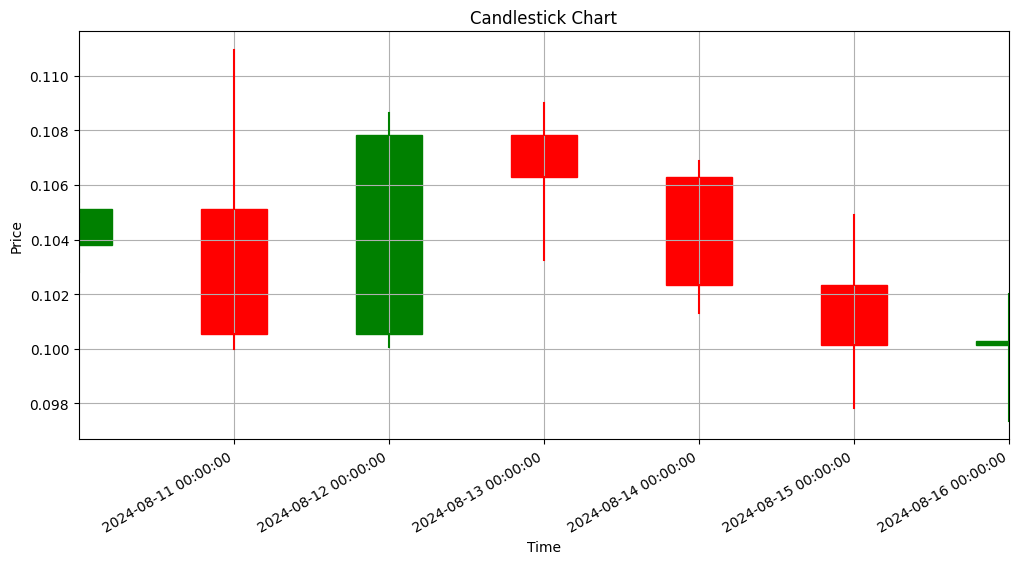

In [64]:
plot_candles(candles=candles['DOGE'])

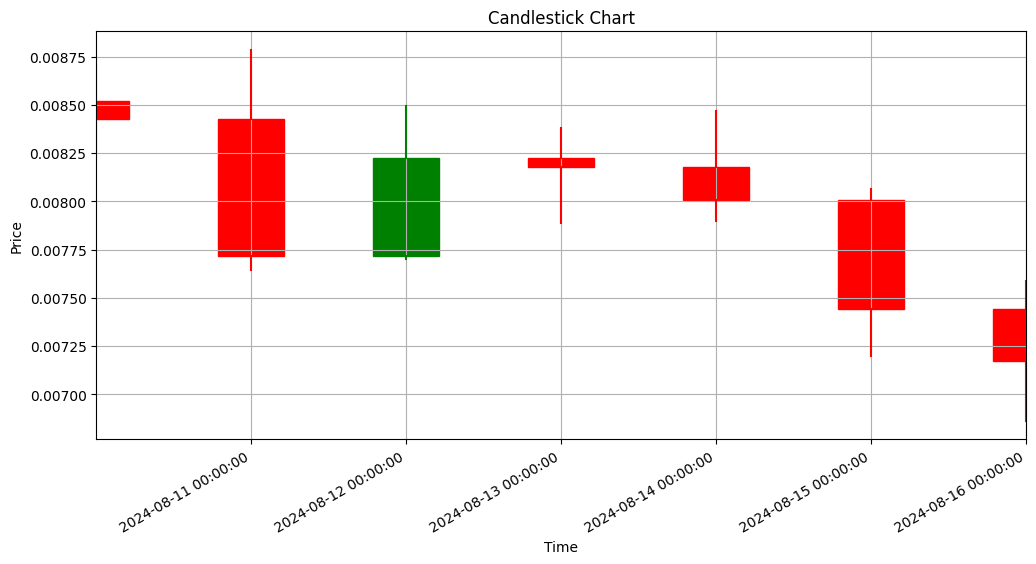

In [63]:
plot_candles(candles=candles['PEPE'])

In [84]:
actions = []
instruments = candles.keys()
CONST_AMOUNT = 1000
for instrument in instruments:
    for candle in candles[instrument]:
        if candle.time_end < time_end - 1000*1000*60 and candle.time_start > time_start + 1000*1000*60:
            if candle.body_open < candle.body_close or candle.body_open > candle.body_close:
                sign = (-1) ** (candle.body_open > candle.body_close)
                actions.append(Action(timestamp=candle.time_start,
                    base_actions=[BaseAction(instrument=instrument, amount=CONST_AMOUNT * sign)]))
                actions.append(Action(timestamp=candle.time_end,
                    base_actions=[BaseAction(instrument=instrument, amount=CONST_AMOUNT * -sign)]))
                
                
                
simulation = Simulate(actions=actions, action_duration=10000)
result = simulation.backtest(bbo_data=bbo_data)

history = result['history']
tm = TradingMetrics(history)

# Рассчет метрик
print("Sharpe Ratio:", tm.calculate_sharpe(market_data=bbo_data))
print("Sortino Ratio:", tm.calculate_shortino(market_data=bbo_data))
print("Traded Volume:", tm.calculate_traded_volume())
print("Total PnL:", tm.calculate_total_pnl(), result['open_positions'])

Sharpe Ratio: {'DOGE': 1.9331844037752863, 'PEPE': 1.6046409332106697}
Shortino Ratio: {'DOGE': nan, 'PEPE': nan}
Traded Volume: 1119.5014
Total PnL: 21.612399999999965 {'DOGE': 0, 'PEPE': 0}


In [73]:
for trade in history.values():
    print(trade['pnl_delta'])

0
0
105.12
-8.427999999999999
8.4291
105.13
-7.718100000000001
-100.54
-100.53
-7.7179
8.2246
107.84
107.84
8.2247
-106.31
-8.1801
8.182699999999999
106.33
-102.36000000000001
-8.006599999999999
8.0058
102.35
-7.4418
-100.14
